There is AA test data from '2022-12-25' to '2022-12-31'. You need to make a simulation, as if 10,000 AA tests were carried out. At each iteration, it is necessary to form subsamples without repetition in 500 users from the 2nd and 3rd experimental groups. Compare these subsamples with a t-test

1. Construct a histogram of the distribution of the resulting 10000 p-values.

2. Calculate what percentage of p-values turned out to be less than or equal to 0.05

3. Write a conclusion on the conducted AA test, whether the splitting system works correctly.

Есть данные АА-теста с '2022-12-25' по '2022-12-31'. Hужно сделать симуляцию, как будто были проведены 10000 АА-тестов. На каждой итерации нужно сформировать подвыборки без повторения в 500 юзеров из 2 и 3 экспериментальной группы. Провести сравнение этих подвыборок t-testом

1. Построить гистограмму распределения получившихся 10000 p-values.

2. Посчитать, какой процент p-values оказался меньше либо равен 0.05

3. Написать вывод по проведенному АА-тесту, корректно ли работает система сплитования.

In [1]:
# Libraries Request   Запрос библиотек
import pandahouse
import pandas as pd
import seaborn as sns
import numpy as np

from scipy import stats

In [2]:
# Create a connection  Создание соединения

connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator'
}

In [3]:
# Data request (users, their views and likes from groups 2 and 3
# during the time interval from 12/25/22 to 12/31/22)
# Запрос данных (пользователи, их просмотры и лайки из групп 2 и 3
#  во временной интервал с 25.12.22 по 31.12.22)

q = """
SELECT  
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr,
    exp_group
    
FROM simulator_20230120.feed_actions

WHERE toDate(time) >= '2022-12-25' and toDate(time) <= '2022-12-31' 
    and exp_group in (2,3)
    
GROUP BY exp_group, user_id
"""

df = pandahouse.read_clickhouse(q, connection=connection)

In [4]:
# We look at the number of users in groups. We need about the same
# Смотрим количество пользователей в группах. Нам нужно примерно одинаковое

df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
2,8480,8480,8480,8480
3,8569,8569,8569,8569


<AxesSubplot:xlabel='ctr', ylabel='Count'>

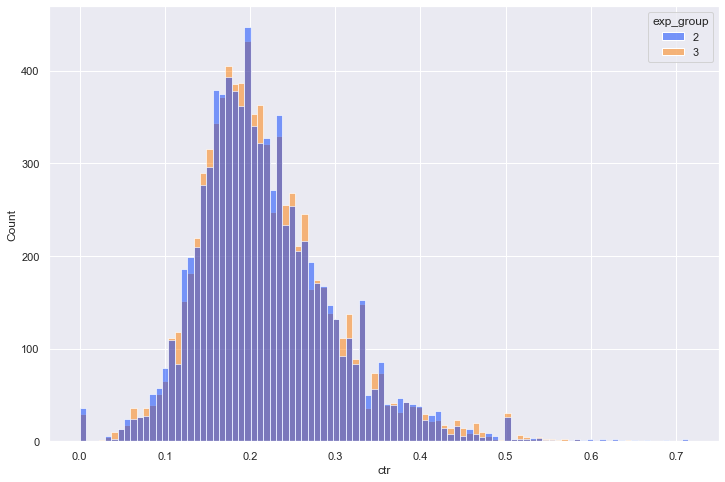

In [7]:
# Visual view of groups in Seaborn
# Визуальный просмотр групп в Seaborn


sns.set(rc={'figure.figsize':(12,8)})

sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = 'bright',
              alpha=0.5,
              kde=False)

In appearance, CTR in groups is distributed equally.   
На вид CTR в группах распределён одинаково.

In [8]:
''' Preparing to simulate 10,000 AA tests.
At each iteration, we will form subsamples without repetition of 500 users from the 2nd and 3rd experimental groups.

Подготовка к симуляции 10000 АА-тестов. 
На каждой итерации будем формировать подвыборки без повторения в 500 юзеров из 2 и 3 экспериментальной группы. 
'''

num_AA = 10000                    # Number of AA tests.             Количество АА тестов
sample_number = 500               # Number of users in each sample. Количество пользователей в каждой выборке
df_2 = df[df.exp_group == 2].ctr  # Column with CTR in the whole group 2. Колонка с CTR во всей группе 2
df_3 = df[df.exp_group == 3].ctr  # Column with CTR in the whole group 3. Колонка с CTR во всей группе 3
p_value_list = np.zeros(num_AA)   # List of p-values, initially filled with zeros.
                                  #Список под значения p-values, изначально заполненный нулями

In [9]:
# List Comprehension to record all p_values in 10000 experiments, in a pre-prepared list
#List Comprhention для записи всех значений p_value в 10000 экспериментах, в заранее подготовленный список

p_value_list = [stats.ttest_ind(df_2.sample(sample_number),df_3.sample(sample_number),equal_var=False).pvalue \
                for _ in range(num_AA)]


In [10]:
'''# Select p-values that are less than the selected threshold of 5%
and calculate the proportion of these values to the total number of tests.
# Выбор значений p-value, которые меньше выбранного порога в 5% 
и вычисление доли этих значений к общему числу тестов.'''

p_value_less_005 = [x for x in p_value_list if x <= 0.05]  # Form a list of values less than 0.05
                                                           # Формируем список из значений меньше 0,05
ratio_p_value_less005 = len(p_value_less_005) / num_AA # Calculate the proportion of p-values that are less than 0.05
                                                       # Вычисляем долю значений p-value, которые меньше 0,05

print(f' The percentage of p-values less than 0.05 is {ratio_p_value_less005*100}')

 The percentage of p-values less than 0.05 is 4.53


In [11]:
# Preparation for building a histogram of the distribution of p-values
# Подготовка для построении гистограммы распределения значений p-value


df_p_value = pd.DataFrame(p_value_list,columns={'p_value'}) # Form pandas DataFrame from p_value_list
                                                            # Формируем pandas DataFrame из списка p_value_list


<AxesSubplot:xlabel='p_value', ylabel='Count'>

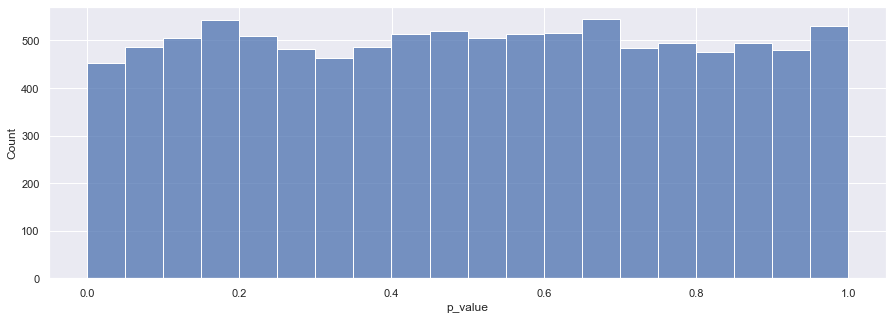

In [12]:
# Building a histogram in Seaborn
# Строим гистограмму в Seaborn

sns.set(rc={'figure.figsize':(15,5)})
sns.histplot(x = df_p_value.p_value, bins = 20)# Take bins = 20 to see how many p-values are less than 0.05
                                               # Берём bins = 20, чтобы видеть количество p-value меньше 0,05

The distribution of p-values seems to be uniform

The number of p-values less than 0.05 does not exceed 5%

This allows us to conclude that splitting works correctly and is suitable for conducting AV tests.

Распределение значений p-value похоже на равномерное

Количество значений p-value меньших 0.05 не превышает 5 %

Это позволяет сделать вывод - сплитование работает корректно и подходит для проведения АВ тестов